<a href="https://colab.research.google.com/github/chjohnso-um/chjohnso-um-CSC-587/blob/main/Milestone_python_collection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

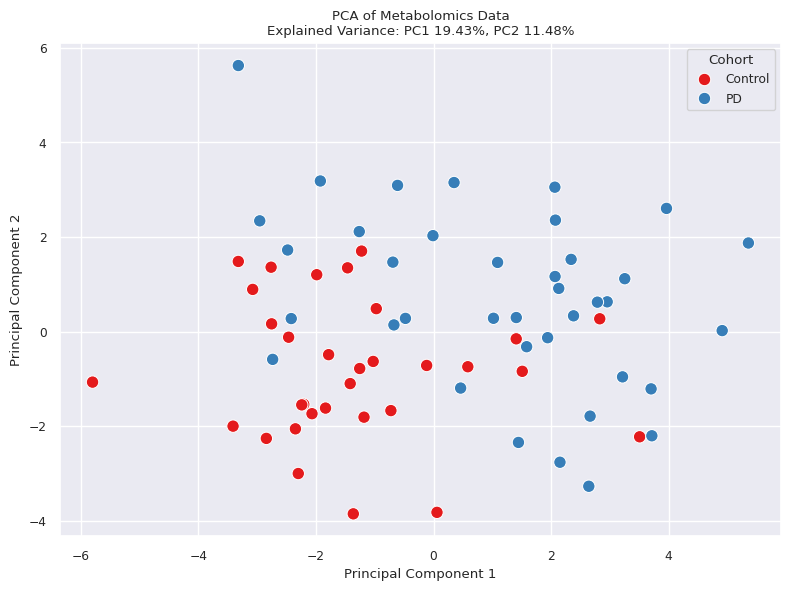

In [42]:
# Full PCA and Plotting Code for Top 30 XGBoost Metabolites data

import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ Replace these with your actual DataFrame and label Series
X_bl = pd.read_csv('/content/top30_xgboost_metabolites.csv')  # e.g., bl_data[top_30_metabolite_columns]
y_bl = bl_data['PPMI_COHORT'].map({'PD': 1, 'Control': 0})      # e.g., bl_data['PPMI_COHORT'].map({'PD': 1, 'Control': 0})

# ✅ Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_bl)

# ✅ Perform PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)

# ✅ Create DataFrame for plotting
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Cohort'] = y_bl.map({0: 'Control', 1: 'PD'})  # Optional: Map numeric labels back to text

# ✅ Plot the PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cohort', palette='Set1', s=80)
plt.title(f'PCA of Metabolomics Data\nExplained Variance: PC1 {pca.explained_variance_ratio_[0]:.2%}, PC2 {pca.explained_variance_ratio_[1]:.2%}')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cohort')
plt.grid(True)
plt.tight_layout()
plt.show()

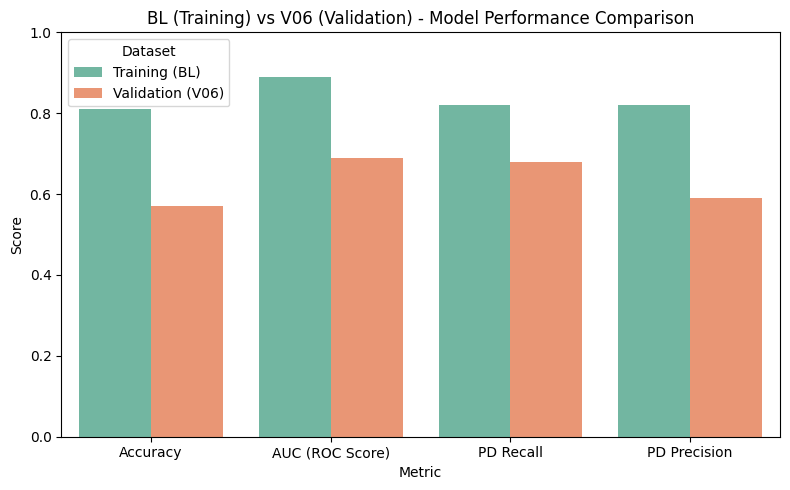

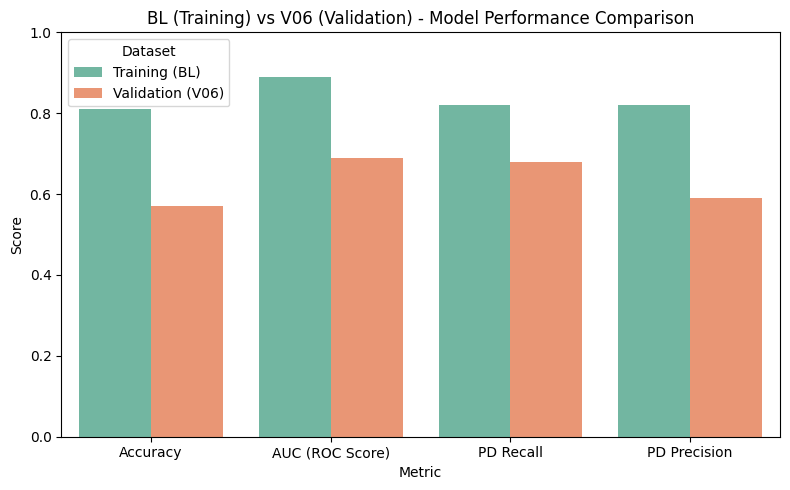

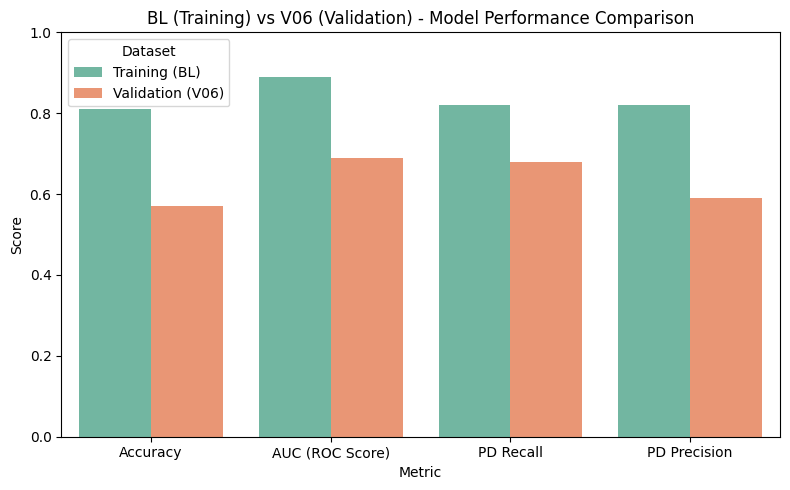

In [13]:
# Model performance comparison between BL and V06

%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Re-create the comparison data
comparison_df = pd.DataFrame({
    'Metric': ['Accuracy', 'AUC (ROC Score)', 'PD Recall', 'PD Precision'],
    'Training (BL)': [0.81, 0.89, 0.82, 0.82],
    'Validation (V06)': [0.57, 0.69, 0.68, 0.59]
})

# Melt for seaborn plotting
comparison_melted = comparison_df.melt(id_vars='Metric', var_name='Dataset', value_name='Score')

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(data=comparison_melted, x='Metric', y='Score', hue='Dataset', palette='Set2')
plt.title('BL (Training) vs V06 (Validation) - Model Performance Comparison')
plt.ylim(0, 1)
plt.ylabel('Score')
plt.tight_layout()

# Save or show the plot
plt.savefig('BL_vs_V06_Performance_Comparison.png', dpi=300)
plt.show()

In [15]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder

# Load your BL dataset
bl_data = pd.read_csv('/content/drive/MyDrive/CSC-587/Milestone/Data/Curated Log Data BL.csv')

# Prepare features and target
y = bl_data['PPMI_COHORT'].map({'PD': 1, 'Control': 0})
feature_cols = [col for col in bl_data.columns if col not in ['PARENT_SAMPLE_NAME', 'PPMI_CLINICAL_EVENT', 'PPMI_COHORT', 'CLIENT_IDENTIFIER']]
X = bl_data[feature_cols].apply(lambda col: col.fillna(col.median()), axis=0)

# Optional log transform of skewed features
skewness = X.skew()
highly_skewed = skewness[abs(skewness) > 2].index.tolist()
for feat in highly_skewed:
    X[feat] = np.log1p(X[feat] - X[feat].min() + 0.01)

# Encode target
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Run XGBoost
xgb_model = xgb.XGBClassifier(
    eval_metric='logloss',
    random_state=42,
    n_estimators=30,
    learning_rate=0.05,
    max_depth=3,
    reg_alpha=1.0,
    reg_lambda=1.0,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False
)
xgb_model.fit(X, y_encoded)

# Get top 30 features
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

top_30_features = feature_importance.head(30)['Feature'].tolist()

# Export to CSV
X[top_30_features].to_csv('top30_xgboost_metabolites.csv', index=False)
print("Exported top 30 features to 'top30_xgboost_metabolites.csv'")

Exported top 30 features to 'top30_xgboost_metabolites.csv'


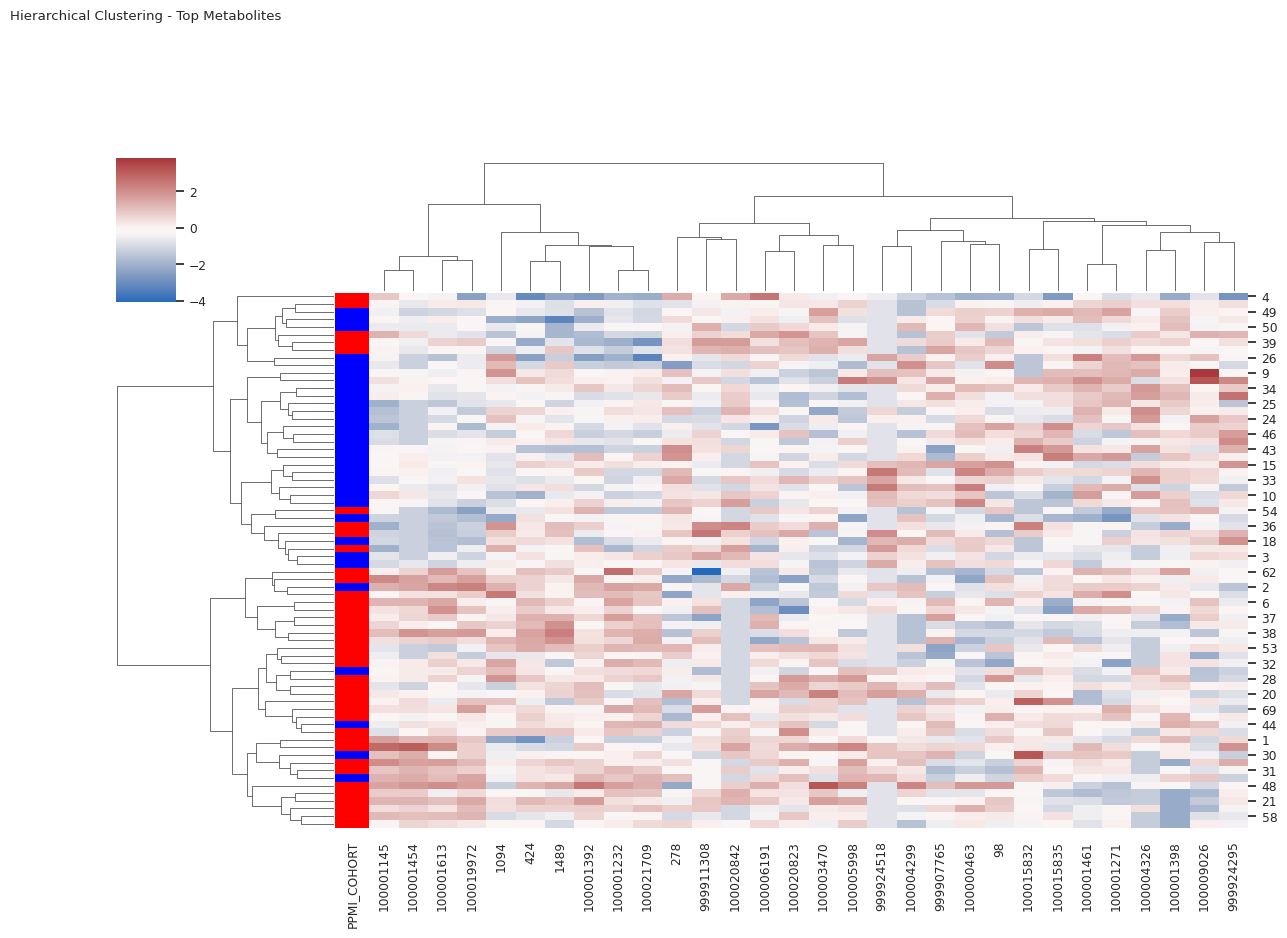

In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Example: Load your processed dataframe with top 30 features
cluster_df = pd.read_csv('/content/top30_xgboost_metabolites.csv')

# Z-score normalization
scaler = StandardScaler()
cluster_data_scaled = scaler.fit_transform(cluster_df)
cluster_df_scaled = pd.DataFrame(cluster_data_scaled, columns=cluster_df.columns)

# Optional: Add patient labels (PD=red, Control=blue)
y_bl = bl_data['PPMI_COHORT'].map({'PD': 1, 'Control': 0})
row_colors = y_bl.map({1: 'red', 0: 'blue'})  # If y_bl is a pandas Series of 1/0 labels

# Plot the clustermap
sns.set(font_scale=0.8)
g = sns.clustermap(
    cluster_df_scaled,
    method='ward',
    metric='euclidean',
    row_colors=row_colors,
    figsize=(12, 8),
    cmap='vlag',
    dendrogram_ratio=(0.2, 0.2),
    cbar_pos=(0.02, 0.8, 0.05, 0.18)
)

plt.title('Hierarchical Clustering - Top Metabolites', pad=100)
plt.show()

In [26]:
# perform Random Forest hyperparameter tuning with cross-validation and output accuracy and AUC scores

import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, roc_auc_score

# Load the data
df = pd.read_csv('/content/drive/MyDrive/CSC-587/Curated Log Data BL.csv')

# Extract features and target
metabolite_columns = df.columns[4:]
metabolite_data = df[metabolite_columns].fillna(0)  # Handle NaNs
target = df['PPMI_COHORT']

# Standardize the metabolite data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(metabolite_data)

# Encode the target
le = LabelEncoder()
target_encoded = le.fit_transform(target)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    scaled_data, target_encoded, test_size=0.3, random_state=42, stratify=target_encoded
)

# Define a lighter hyperparameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt']
}

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    param_distributions=param_grid,
    n_iter=5,
    cv=3,
    scoring='roc_auc',
    random_state=42,
    n_jobs=-1
)

# Run the search
random_search.fit(X_train, y_train)

# Evaluate the tuned model
best_rf = random_search.best_estimator_
y_pred = best_rf.predict(X_test)
y_prob = best_rf.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_prob)

# Output results
print("Best Parameters:", random_search.best_params_)
print("Accuracy on Test Set:", round(accuracy, 3))
print("AUC on Test Set:", round(auc_score, 3))

# Add this snippet at the end of the script (after AUC calculation):
# Extract feature importances
import numpy as np

feature_importances = best_rf.feature_importances_
importance_df = pd.DataFrame({
    'Metabolite': metabolite_columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Show top 10 most important features
print("\nTop 10 Important Metabolites:")
print(importance_df.head(10))

# Export full feature importance list to CSV
importance_df.to_csv('RandomForest_Feature_Importance.csv', index=False)
print("\nFeature importances saved to RandomForest_Feature_Importance.csv")

Best Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None}
Accuracy on Test Set: 0.667
AUC on Test Set: 0.777

Top 10 Important Metabolites:
     Metabolite  Importance
1064  100020823    0.017621
1427  999924585    0.013851
718   100005996    0.010989
507   100001992    0.010134
385   100001402    0.009589
218   100000039    0.009182
1046  100020622    0.008914
497   100001925    0.008407
60          358    0.008333
1303  999917612    0.008261

Feature importances saved to RandomForest_Feature_Importance.csv


In [27]:
# Full Python Code Snippet to Add After Model Evaluation:
from scipy.stats import ttest_ind

# Run t-test for each metabolite (PD vs. Control)
control_group = df[df['PPMI_COHORT'] == 'Control'][metabolite_columns]
pd_group = df[df['PPMI_COHORT'] == 'PD'][metabolite_columns]

p_values = []
for metabolite in metabolite_columns:
    control_values = control_group[metabolite].dropna()
    pd_values = pd_group[metabolite].dropna()
    if len(control_values) > 2 and len(pd_values) > 2:
        stat, p_val = ttest_ind(control_values, pd_values, equal_var=False)
    else:
        p_val = np.nan
    p_values.append(p_val)

# Create DataFrame with p-values
pval_df = pd.DataFrame({
    'Metabolite': metabolite_columns,
    'P_Value': p_values
})

# Merge feature importance with p-values
importance_df = pd.DataFrame({
    'Metabolite': metabolite_columns,
    'Importance': feature_importances
})

combined_df = importance_df.merge(pval_df, on='Metabolite')
combined_df.sort_values(by='Importance', ascending=False, inplace=True)

# Export combined data
combined_df.to_csv('RF_Feature_Importance_with_PValues.csv', index=False)
print("\nCombined feature importance and p-values saved to RF_Feature_Importance_with_PValues.csv")

# Optional: Display top 10
print("\nTop 10 Metabolites by RF Importance with P-Values:")
print(combined_df.head(10))



Combined feature importance and p-values saved to RF_Feature_Importance_with_PValues.csv

Top 10 Metabolites by RF Importance with P-Values:
     Metabolite  Importance   P_Value
1064  100020823    0.017621  0.008064
1427  999924585    0.013851  0.022838
718   100005996    0.010989  0.000664
507   100001992    0.010134  0.342784
385   100001402    0.009589  0.076261
218   100000039    0.009182  0.169452
1046  100020622    0.008914  0.004074
497   100001925    0.008407  0.007361
60          358    0.008333  0.144166
1303  999917612    0.008261  0.001017


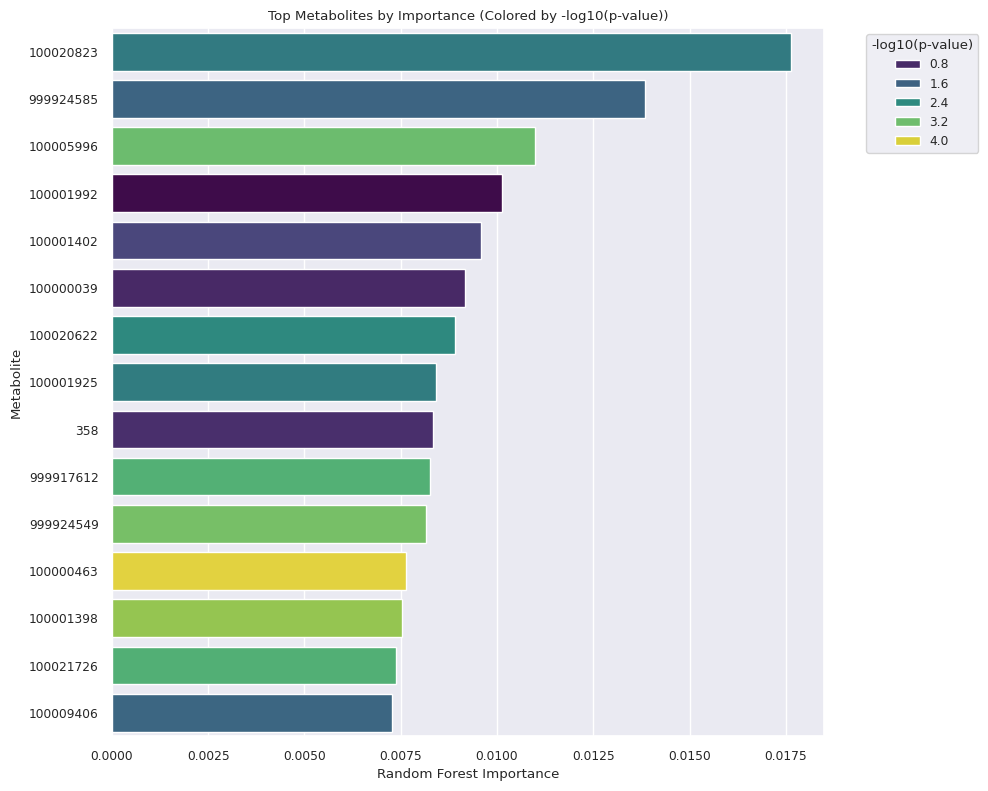

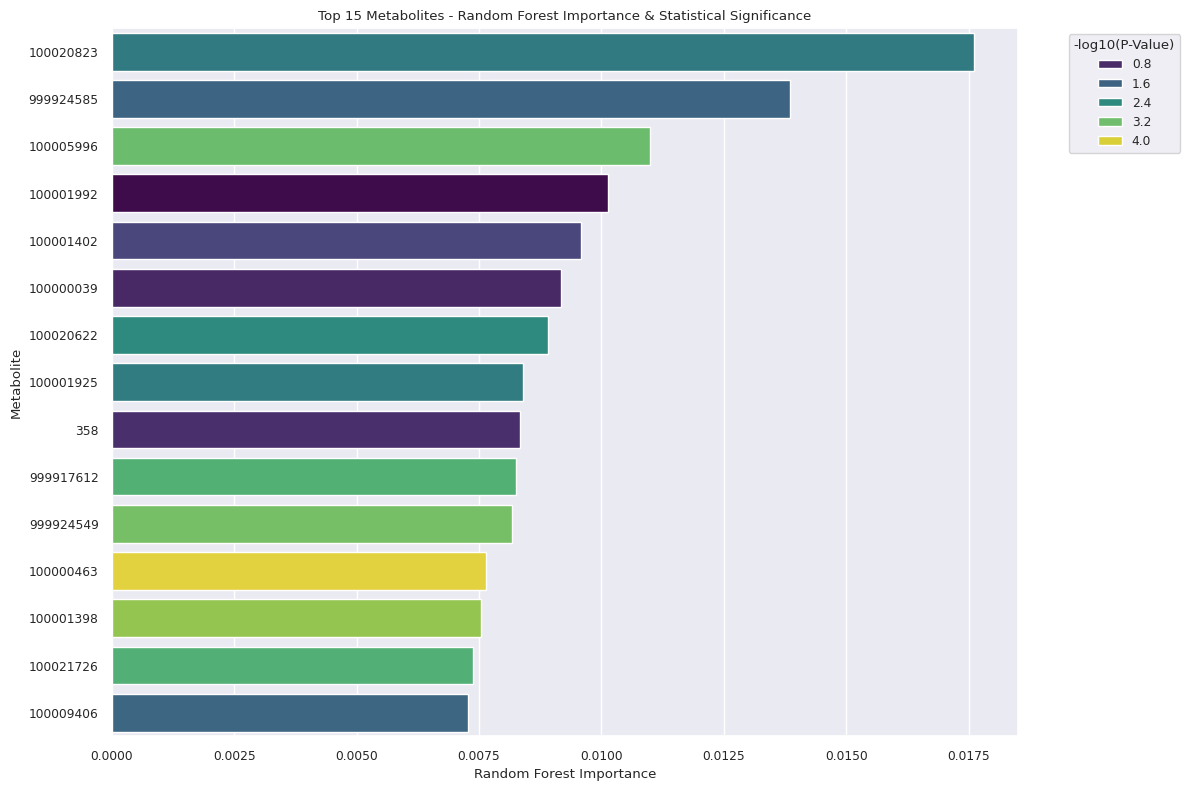

In [28]:
# Python Code for Plotting the Combined Ranking
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Optional: Filter only metabolites with p-value < 0.05 if desired
filtered_df = combined_df.copy()  # or use: combined_df[combined_df['P_Value'] < 0.05]

# Plot the top 15 metabolites by importance
top_combined = filtered_df.head(15)

# Convert p-values to -log10 scale for better visualization
top_combined['-log10(P_Value)'] = -np.log10(top_combined['P_Value'].replace(0, np.nan))

plt.figure(figsize=(10, 8))
sns.barplot(
    data=top_combined,
    x='Importance',
    y='Metabolite',
    hue='-log10(P_Value)',
    dodge=False,
    palette='viridis'
)

plt.xlabel('Random Forest Importance')
plt.ylabel('Metabolite')
plt.title('Top Metabolites by Importance (Colored by -log10(p-value))')
plt.legend(title='-log10(p-value)', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# -----

# Plotting Combined Random Forest Importance and P-Values
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Optional: Load combined_df if running in a new session
# combined_df = pd.read_csv('RF_Feature_Importance_with_PValues.csv')

# Optional: Filter significant p-values (Uncomment to activate filter)
# combined_df = combined_df[combined_df['P_Value'] < 0.05]

# Create -log10(p-value) for better visualization scale
combined_df['-log10(P_Value)'] = -np.log10(combined_df['P_Value'].replace(0, np.nan))

# Select top 15 by importance
top_combined = combined_df.sort_values(by='Importance', ascending=False).head(15)

# Plotting
plt.figure(figsize=(12, 8))
sns.barplot(
    data=top_combined,
    x='Importance',
    y='Metabolite',
    hue='-log10(P_Value)',
    palette='viridis',
    dodge=False
)

plt.xlabel('Random Forest Importance')
plt.ylabel('Metabolite')
plt.title('Top 15 Metabolites - Random Forest Importance & Statistical Significance')
plt.legend(title='-log10(P-Value)', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [36]:
# Full Python Code to Extract Clustered Patient Order:

# Assuming 'g' is your clustermap object created earlier
# And 'bl_data' is your original dataset (with sample IDs and cohort labels)

# Step 1: Get the sample order from the clustering dendrogram
sample_order = g.dendrogram_row.reordered_ind

# Step 2: Extract the corresponding sample names and cohort labels in that order
ordered_samples = bl_data.iloc[sample_order][['PARENT_SAMPLE_NAME', 'PPMI_COHORT']].reset_index(drop=True)

# Step 3: Display the ordered list
print(ordered_samples)

# Optional: Save the ordered list to CSV
ordered_samples.to_csv('clustered_patient_order.csv', index=False)
print("Clustered patient order saved as 'clustered_patient_order.csv'")

   PARENT_SAMPLE_NAME PPMI_COHORT
0          FORD-01886          PD
1          FORD-02025          PD
2          FORD-02030     Control
3          FORD-02009     Control
4          FORD-02033     Control
..                ...         ...
65         FORD-01895          PD
66         FORD-01944          PD
67         FORD-02011          PD
68         FORD-02051          PD
69         FORD-02052          PD

[70 rows x 2 columns]
Clustered patient order saved as 'clustered_patient_order.csv'
